<a href="https://colab.research.google.com/github/Zaki171/Image-Classification-From-Scratch/blob/main/Image_Classification_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test

#end_test

# Loading the data

In [ ]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [ ]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

# Plot Functions

In [ ]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

In [ ]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [ ]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [ ]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [ ]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

IRIS dataset

In [ ]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

MNIST dataset

In [ ]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

In [ ]:
def nsolve(X,y): #Normal Equation
    w = np.matmul(np.linalg.inv(np.matmul(X.transpose(),X)), X.transpose()).dot(y)
    return w

In [ ]:
def line_fit(X,y): #line fitting using normal equation

    X0 = np.ones((X.shape[0],1)) 
    X = np.hstack((X0, X)) #this accounts for the bias term
    w = nsolve(X,y)
    y_pred = X.dot(w.transpose())
    l2_error = (y - y_pred)**2
    l2_error = np.sqrt(l2_error.sum())


    return w, l2_error

Testing on training and test data from IRIS:

In [ ]:
w, error = line_fit(X_iris[:, [0,1,3]], X_iris[:, 2])
print(error) #from train set
X_test = X_iris_test[:, [0,1,3]]
X0 = np.ones((X_test.shape[0],1))
X_test = np.hstack((X0, X_test))
y_test = X_iris_test[:, 2]
y_pred = X_test.dot(w.transpose()) #prediction using trained w
l2_error_test = (y_test-y_pred)**2
l2_error_test = np.sqrt(l2_error_test.sum())
print(l2_error_test)


3.534583205431446
1.5611901785495337


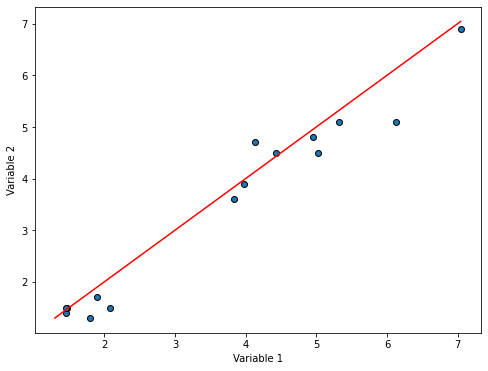

In [ ]:
plot_correlation(y_pred, X_iris_test[:, 2])

In [ ]:
def poly_fit(X,y): #fitting a polynomial equation that takes all possible pairwise combination of features

    X0 = np.ones((X.shape[0],1))
    num_features = X.shape[1]
    for i in range(num_features): #i and j are features
      for j in range(num_features):
        temp = np.multiply(X[:,i],X[:,j])
        temp = temp.reshape(-1,1)
        X = np.hstack((X, temp))
    X = np.unique(X, axis=1) #remove duplicate terms
    X = np.hstack((X0, X))
    w = nsolve(X,y)
    y_pred = X.dot(w.transpose())
    l2_error = (y - y_pred)**2
    l2_error = np.sqrt(l2_error.sum())

    return w, l2_error

Testing on IRIS

In [ ]:
w, train_error = poly_fit(X_iris[:, [0,1,2]], X_iris[:,3])
X0 = np.ones((X_iris_test.shape[0],1))
num_features = 3
X = X_iris_test[:, [0,1,2]]
for i in range(num_features):
  for j in range(num_features):
    temp = np.multiply(X_iris_test[:,i],X_iris_test[:,j])
    temp = temp.reshape(-1,1)
    X = np.hstack((X, temp))
X = np.unique(X, axis=1)
X = np.hstack((X0, X))
preds = X.dot(w.transpose())
l2_error = (X_iris_test[:,3] - preds)**2
l2_error = np.sqrt(l2_error.sum())
print(l2_error)

0.8621833315666116


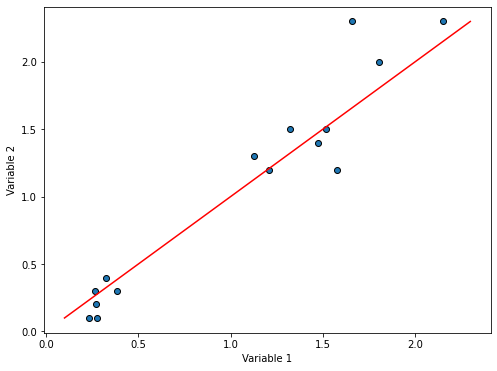

In [ ]:
plot_correlation(preds, X_iris_test[:, 3])

## Optimization Methods

Gradient Descent (standard):

In [ ]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    minimizer  = parameters.copy()
    current_it = 0
    
    for i in range(max_iterations):
      prev_minimizer = minimizer
      minimizer = minimizer - (step_size * d_objective(minimizer)) #descent so subtract to go down
      error = ((prev_minimizer-minimizer)**2).mean() #calculate minimum change by mse
      if error < eps_change:
        break
    current_it = i    

        
    return minimizer, current_it + 1

Gradient Descent (Nesterov Momentum):

In [ ]:
def gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change):
    #nesterov momentum is useful for preventing zig-zag oscillations close to solution
    minimizer  = parameters.copy()
    current_it = 0

    vt1 = 0
    for i in range(max_iterations):
      prev_minimizer = minimizer
      vt0 = vt1
      vt1 = (momentum*vt0) - (step_size*(d_objective(prev_minimizer + (momentum*vt0))))
      minimizer = prev_minimizer + vt1
      error = ((prev_minimizer-minimizer)**2).mean()
      if error < eps_change:
        break

    current_it = i

        
    return minimizer, current_it + 1

Second-order optimization:

In [ ]:
def second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change):

    minimizer  = parameters.copy()
    current_it = 0

    for i in range(max_iterations):
      prev_minimizer = minimizer
      minimizer = prev_minimizer - np.linalg.inv(dd_objective(prev_minimizer)).dot(d_objective(prev_minimizer))
      error = ((prev_minimizer-minimizer)**2).mean()
      if error < eps_change:
        break
    current_it = i


        
    return minimizer, current_it + 1

## Clustering Methods

PCA: Dimensionality reduction with the aim of retaining as much variance as possible

> Why?


*   Reduces training time
*   Reduces noise

PCA finds a new set of dimensions such that all the dimensions are orthogonal (and hence linearly independent) and ranked according to variance.
The new dimensions should minimize projection error while having max spread.



In [ ]:
def pca(X, ndims):
    mean_vec = X.mean(axis = 0, keepdims=True)
    X = X - mean_vec #normalisation
    cov = np.cov(X.T) #matrix representing covariance between each feature
    eig_vals, eig_vecs = np.linalg.eig(cov) #eigenvectors point in the direction of max variance and eigenvalues indicate importance
    #eigenvectors are orthogonal because they span the vector space
    eig_vecs = eig_vecs.T #transpose for sorting
    idxs = np.argsort(eig_vals)[::-1] #returns indices to sort array
    eig_vals = eig_vals[idxs]
    eig_vecs = eig_vecs[idxs]
    top_eig_vecs = eig_vecs[:ndims]


    return mean_vec, top_eig_vecs

Testing:

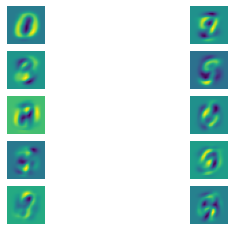

In [ ]:
mean, top_comp = pca(X_mnist, 10) #Top 10 components

plot_eigenvecs(top_comp, 5,2)

In [ ]:
def pca_projection(X, mean_vec, eig_vecs):

    X_scaled = X - mean_vec
    weights = X_scaled.dot(eig_vecs)#re-orientation of data to new axis

    return weights

In [ ]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
 
    reconstruction = weights.dot(eig_vecs.T) + mean_vec 


    return reconstruction

Reconstruction from PCA with all components:

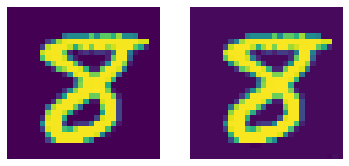

In [ ]:
mean, top_comp = pca(X_mnist, X_mnist.shape[1]) 

first_image = X_mnist_test[0].reshape(1,784)
weights = pca_projection(first_image, mean, top_comp)
reconstruction = pca_reconstruction(weights, mean, top_comp)
stacked_images = np.vstack((first_image, reconstruction))
plot_eigenvecs(stacked_images, 1, 2)

K-means Clustering

> Useful for identifying patterns within data



In [ ]:
def kmeans(X, k, max_iterations=1000):

    clusters = [[] for i in range(k)]
    rand_idxs = np.random.choice(X.shape[0], k, replace=False)
    centroids = [X[i] for i in rand_idxs]
    for i in range(max_iterations):
      for idx, val in enumerate(X):
        distances = [np.sqrt(np.sum((val-c)**2)) for c in centroids]
        closest_idx = np.argmin(distances)
        clusters[closest_idx].append(idx)#map value to the centroid it is closest to

      old_centroids = centroids
      for cluster_idx, cluster in enumerate(clusters):
        cluster_mean = np.mean(X[cluster], axis=0) #get new centroid
        centroids[cluster_idx] = cluster_mean
      cent_dist = [np.sqrt(np.sum((old_centroids[i]-centroids[i])**2)) for i in range(len(centroids))]
      if sum(cent_dist) < 0.01: #used to speed up algorithm
        break


    return centroids

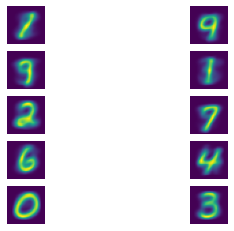

In [ ]:
ideal_centroids = kmeans(X_mnist, 10)
he = np.reshape(ideal_centroids, (10,784))

plot_eigenvecs(he, 5, 2)

## Linear Classification

Binary classification

In [ ]:
def lclass(examplesA, examplesB, testExample):

    X = np.vstack((examplesA, examplesB))
    y1 = np.zeros(examplesA.shape[0])#examplesA have class 0
    y2 = np.ones(examplesB.shape[0])#examplesB have class 1
    y = np.hstack((y1,y2))
    w, error = line_fit(X,y)#fit the line
    X0 = np.ones((testExample.shape[0],1))
    testExample = np.hstack((X0, testExample))
    y_pred = testExample.dot(w.transpose())
    for i in range(y_pred.shape[0]):
      if y_pred[i] > 0.5:
        y_pred[i] = 1 #its B
      else:
        y_pred[i] = 0 #its A
    
    preds = y_pred


    return preds

Testing:

In [ ]:
results = []

matA = np.empty(shape=[1,4])
matB = np.empty(shape=[1,4])
for i in range(X_iris.shape[0]):
  if (Y_iris[i] == 0):
    matA = np.vstack((matA, X_iris[i]))#matA has Iris Setosa samples 
  else:
    matB = np.vstack((matB, X_iris[i]))#matB has all others
preds = lclass(matA, matB, X_iris_test)
reals = np.zeros((Y_iris_test.shape[0]))
for i in range (Y_iris_test.shape[0]):
  if Y_iris_test[i] == 0:
    reals[i] = 0
  else:
    reals[i] = 1
results.append((preds,reals))

matA = np.empty(shape=[1,4])
matB = np.empty(shape=[1,4])
for i in range(X_iris.shape[0]):
  if (Y_iris[i] == 1):
    matA = np.vstack((matA, X_iris[i]))#matA has Iris Versicolour samples 
  else:
    matB = np.vstack((matB, X_iris[i]))#matB has all others
preds = lclass(matA, matB, X_iris_test)
reals = np.zeros((Y_iris_test.shape[0]))
for i in range (Y_iris_test.shape[0]):
  if Y_iris_test[i] == 1:
    reals[i] = 0
  else:
    reals[i] = 1
results.append((preds, reals))

matA = np.empty(shape=[1,4])
matB = np.empty(shape=[1,4])
for i in range(X_iris.shape[0]):
  if (Y_iris[i] == 2):
    matA = np.vstack((matA, X_iris[i]))#matA has Iris Virginica samples 
  else:
    matB = np.vstack((matB, X_iris[i]))#matB has all others
preds = lclass(matA, matB, X_iris_test)
reals = np.zeros((Y_iris_test.shape[0]))
for i in range (Y_iris_test.shape[0]):
  if Y_iris_test[i] == 2:
    reals[i] = 0
  else:
    reals[i] = 1
results.append((preds, reals))

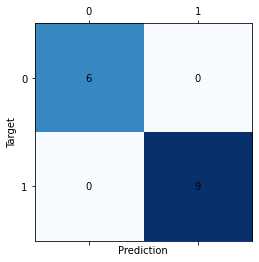

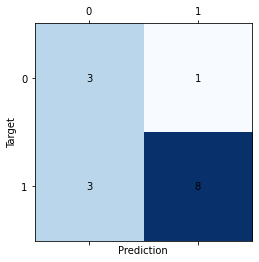

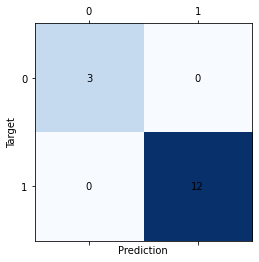

In [ ]:
for tup in results:
  plot_confusion_matrix(tup[0], tup[1])

Multiclass Classification:

In [ ]:
def softmax(preds):

  #predictions are passed such that the each column represents a different class
  e = np.exp(preds)
  activation = e.T/e.sum(axis=1)



  return activation

In [ ]:
def lclass_prob(examplesA, examplesB, testExample):

    X = np.vstack((examplesA, examplesB))
    y1 = np.ones(examplesA.shape[0])
    y2 = np.zeros(examplesB.shape[0])
    y = np.hstack((y1,y2))
    w, error = line_fit(X,y)#fit the line
    X0 = np.ones((testExample.shape[0],1))
    testExample = np.hstack((X0, testExample))
    preds = testExample.dot(w.transpose())

    
    return preds

In [ ]:
def lmclass(examples, labels, testExample):

    preds = []
    for label in np.unique(labels): #np.unique returns a sorted list of unique elements, so we start with 0,1,2...
      examplesA = examples[labels == label]
      examplesB = examples[labels != label]
      next_pred = lclass_prob(examplesA, examplesB, testExample)
      preds.append(next_pred)

    pred_matrix = (np.reshape(preds, (np.unique(labels).shape[0], testExample.shape[0]))).T
    
    preds_prob = softmax(pred_matrix).T
    
    return preds_prob

In [ ]:
preds_prob = lmclass(X_iris, Y_iris, X_iris_test)
accuracy = 0

for i in range(X_iris_test.shape[0]):
  print(f'predicted:{np.argmax(preds_prob[i])}', f'actual:{Y_iris_test[i]}')#In this case the column number of preds_prob will be compared with the values in Y_iris_test - this testing may not work for other datasets
  if np.argmax(preds_prob[i])==Y_iris_test[i]:
    accuracy = accuracy + 1
print(f'accuracy = {accuracy/X_iris_test.shape[0]}')


predicted:1 actual:1
predicted:0 actual:0
predicted:2 actual:2
predicted:2 actual:1
predicted:1 actual:1
predicted:0 actual:0
predicted:2 actual:1
predicted:2 actual:2
predicted:1 actual:1
predicted:1 actual:1
predicted:2 actual:2
predicted:0 actual:0
predicted:0 actual:0
predicted:0 actual:0
predicted:0 actual:0
accuracy = 0.8666666666666667


## Non-linear Classification

In [ ]:
def gd(X, Y, W,loss_function, loss_gradient, step_size, max_it):

    history = [] 
    for i in range(max_it):
      preds = predict(X,W)
      history.append(loss_function(preds,Y))
      prev_W = W
      W = W - (step_size*loss_gradient(preds,X,Y,W))

    best_w = W

    
    return history, best_w

In [ ]:
def sigmoid(z):

    activation = 1.0/(1.0+np.exp(-z))

    return activation

def predict(X, W):

    X0 = np.ones((X.shape[0],1))
    X = np.hstack((X0,X))
    preds = X.dot(W.transpose())
    prediction = sigmoid(preds)


    
    return prediction

In [ ]:
def logistic_loss(preds, targets):

    cost = (-targets * np.log(preds) - (1 - targets) * np.log(1 - preds)).mean()



    return cost

In [ ]:
def dlogistic(preds, X, Y,W=[]):

    X0 = np.ones((X.shape[0],1))
    X = np.hstack((X0,X))
    J = (1/preds.shape[0]) * np.dot(X.T, (preds-Y))

    return J

In [ ]:
#Classes names are: Iris Setosa for label 0, Iris Versicolour for label 1, and Iris Virginica for label 2.
y = np.zeros((Y_iris.shape[0]))
for i in range (Y_iris.shape[0]):
  if Y_iris[i] == 0: #Test for Setosa
    y[i] = 1 
  else:
    y[i] = 0
y_test = np.zeros((Y_iris_test.shape[0]))
for i in range (Y_iris_test.shape[0]):
  if Y_iris_test[i] == 0:
    y_test[i] = 1
  else:
    y_test[i] = 0

history, best_w = gd(X_iris, y, np.zeros(X_iris.shape[1]+1), logistic_loss, dlogistic, 0.1, 500)

preds = predict(X_iris_test, best_w)
for i in range(preds.shape[0]):
  if preds[i] > 0.5:
    preds[i] = 1
  else:
    preds[i] = 0

print('predictions:', preds)
print('real values:', y_test)


predictions: [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
real values: [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


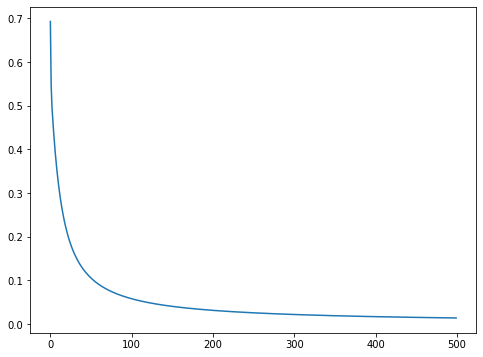

In [ ]:

plot_loss_curve(history)

## Neural Network (3-layer):

In [ ]:
def sigmoid(z):

    activation = 1.0/(1.0+np.exp(-z))

    return activation

def dsigmoid(z):

    gradient = sigmoid(z)*(1-sigmoid(z))


    return gradient

In [ ]:

def forward_pass(x, W, b):

    z1 = np.dot(W[0], x) +b[0]#hidden state 1
    a1 = sigmoid(z1)
    z2 = np.dot(W[1], a1) +b[1] #hidden state 2
    a2 = sigmoid(z2)
    z3 = np.dot(W[2], a2)+b[2]
    a3 = sigmoid(z3)#final output
    cache = ((z1,a1), (z2,a2), (z3,a3))
    y_hat = a3
    
    return y_hat, cache

In [ ]:
def loss(preds, targets):


    cost = ((preds-targets)**2).mean()
    
    return cost

def dloss(preds, target):


    gradient = 2*(preds - target)/preds.shape[0]


    return gradient

In [ ]:
def backward_pass(preds, targets, W, b, X, cache):


    m = targets.shape[0]
    a1 = cache[0][1]
    a2 = cache[1][1]
    a3 = cache[2][1]
    z1 = cache[0][0]
    z2 = cache[1][0]
    z3 = cache[2][0]
    dz3 = dloss(a3,targets)
    J_w3 = (1/m)*np.dot(dz3, a2.T) #loss with respect to w3
    J_b3 = (1/m) * np.sum(dz3, axis = 1, keepdims=True) #we have to update the bias as well
    dz2 = np.multiply(np.dot(W[2].T, dz3), dsigmoid(a2))
    J_w2 = (1/m)*np.dot(dz2, a1.T) #wrt to w2
    J_b2 = (1/m)*np.sum(dz2, axis = 1, keepdims=True)
    dz1 = np.multiply(np.dot(W[1].T, dz2), dsigmoid(a1))
    J_w1 = (1/m)*np.dot(dz1, X.T)
    J_b1 = (1/m)*np.sum(dz1, axis=1, keepdims=True)

    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

In [ ]:
def training(X, Y, W, b, step_size, max_it):

    W = list(W)
    b = list(b)
    bs = 100 #batch size
    m = X.shape[0]
    for i in range(max_it): #Stochastic Gradient Descent
      batch = np.random.randint(X.shape[0], size = bs)
      X_b = (X[batch,:]).T #transpose for easier calculations
      Y_b = Y[batch]
      y_hat, cache = forward_pass(X_b,W,b)
      J_w3, J_w2, J_w1, J_b3, J_b2, J_b1 = backward_pass(y_hat, Y_b, W, b, X_b, cache)
      W[0] = W[0] - step_size*J_w1 #updates
      W[1] = W[1] - step_size*J_w2
      W[2] = W[2] - step_size*J_w3
      b[0] = b[0] - step_size*J_b1
      b[1] = b[1] - step_size*J_b2
      b[2] = b[2] - step_size*J_b3
      history.append(loss(Y_b, y_hat))
      if i % 100 == 0:
        print(f'loss at iteration {i}: {history[-1]}')

            
    return W, b, history

In [ ]:



np.random.seed(10)
#Layer structure can be changed - I chose [784, 128,64,1]
W = ((np.random.randn(128, 784)*np.sqrt(1./128)), (np.random.randn(64, 128)*np.sqrt(1./64)), (np.random.randn(1, 64))) #used randn for initialization
b= ((np.random.randn(128, 1)), (np.random.randn(64, 1)), (np.random.randn(1,1)))
Y_1 = np.empty(Y_mnist.shape[0]) #encoding 
for i in range(Y_mnist.shape[0]):
  if Y_mnist[i] == 1: #classify digits on whether they are 1 or not 
    Y_1[i] = 1
  else:
    Y_1[i] = 0

Y_1_test = np.empty(Y_mnist_test.shape[0])
for i in range(Y_mnist_test.shape[0]):
  if Y_mnist_test[i] == 1:
    Y_1_test[i] = 1
  else:
    Y_1_test[i] = 0

W, b , history = training(X_mnist, Y_1, W, b, 0.01, 1000) #lr of 0.01 and 1000 iterations

y_pred, cache = forward_pass(X_mnist_test.T, W, b)
y_pred = y_pred.reshape((7000))
accuracy = 0

for i in range(y_pred.shape[0]):
  if y_pred[i] > 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0
  if y_pred[i] == Y_1_test[i]:
    accuracy = accuracy + 1

print(f'accuracy: {accuracy/y_pred.shape[0]}')




#end_solution




loss at iteration 0: 0.11873509737041467
loss at iteration 100: 0.052872575326985034
loss at iteration 200: 0.055071710511024816
loss at iteration 300: 0.03553325010633781
loss at iteration 400: 0.025862018825658088
loss at iteration 500: 0.028806951893127274
loss at iteration 600: 0.028685097578601097
loss at iteration 700: 0.023738045963277728
loss at iteration 800: 0.02580494243416896
loss at iteration 900: 0.02459075102200726
accuracy: 0.9822857142857143
